### Import libraries

In [38]:
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import researchpy as rp
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy


### Data import and wrangling for model

Let's start with loading the cleaned data after the EDA1

In [2]:
df=pd.read_csv("./houses_data_clean.csv")
df.head()

,Unnamed: 0,Id,MSSubClass,MSZoning,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,...,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,OverallCond_bin,FullBath_bin,ExterQual_bin,KitchenQual_bin
0,0,142,20,RL,CollgCr,1Story,7,2005,2005,VinylSd,...,0,Attchd,Fin,2,660,260000,1,1,0,0
1,1,170,20,RL,Timber,1Story,8,1981,1981,Plywood,...,1,Attchd,RFn,2,511,228000,0,1,0,1
2,2,303,20,RL,CollgCr,1Story,7,2001,2002,VinylSd,...,1,Attchd,RFn,3,843,205000,1,1,0,0
3,3,371,60,RL,Gilbert,2Story,6,2000,2000,VinylSd,...,1,Attchd,RFn,2,460,172400,1,1,1,1
4,4,412,190,RL,Gilbert,1Story,5,1955,1955,Wd Sdng,...,0,Attchd,Fin,2,572,145000,1,0,1,1


In [3]:
#check column types
pd.value_counts(df.dtypes)

int64     16
object    11
dtype: int64

Object types are most likely string data. Let's check it:

In [4]:
#Inspect which columns are of object type
pd.set_option('display.max_columns', 30)
print(df.select_dtypes(exclude="number"))

     MSZoning Neighborhood HouseStyle Exterior1st Exterior2nd MasVnrType  \
0          RL      CollgCr     1Story     VinylSd     VinylSd       None   
1          RL       Timber     1Story     Plywood     Plywood    BrkFace   
2          RL      CollgCr     1Story     VinylSd     VinylSd    BrkFace   
3          RL      Gilbert     2Story     VinylSd     VinylSd       None   
4          RL      Gilbert     1Story     Wd Sdng     Wd Sdng       None   
...       ...          ...        ...         ...         ...        ...   
1455       RL        NAmes     1Story     VinylSd     VinylSd       None   
1456       RM       IDOTRR     2Story     VinylSd     Wd Shng       None   
1457       RL      Edwards     1.5Fin     MetalSd     MetalSd       None   
1458       RL      NPkVill     2Story     Plywood     Brk Cmn       None   
1459       RL      NPkVill     1Story     Plywood     Plywood       None   

     Foundation BsmtQual BsmtFinType1 GarageType GarageFinish  
0         PConc       G

In [5]:
#Switching data types from object to string
for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.Series(df[col], dtype="string")
        
pd.value_counts(df.dtypes)

int64     16
string    11
dtype: int64

The string data will have to be encoded, but so will some of the others, the ones that are more categorical/ordinal. Let's mark those variables, wchich are such

In [6]:
col_ordinal=[col for col in df.select_dtypes(include=["number"]).columns if 1.*df[col].nunique()/df[col].count() < 0.05]
col_ordinal

['MSSubClass',
 'OverallQual',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'OverallCond_bin',
 'FullBath_bin',
 'ExterQual_bin',
 'KitchenQual_bin']

The "$_bin" variables are in fact already encoded, so we should leave them out when encoding in future

In [7]:
col_to_encode=[col for col in df.select_dtypes(exclude=["number"]).columns]
col_to_encode.extend([col for col in col_ordinal if col.find("_bin") == -1])
col_to_encode

['MSZoning',
 'Neighborhood',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'BsmtQual',
 'BsmtFinType1',
 'GarageType',
 'GarageFinish',
 'MSSubClass',
 'OverallQual',
 'YearRemodAdd',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

So now let's encode using one hot encoding in Pandas

In [8]:
df_encoded=pd.get_dummies(df, columns=col_to_encode, drop_first = True)
df_encoded.head()

,Unnamed: 0,Id,YearBuilt,GrLivArea,GarageArea,SalePrice,OverallCond_bin,FullBath_bin,ExterQual_bin,KitchenQual_bin,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Neighborhood_Blueste,...,TotRmsAbvGrd_6,TotRmsAbvGrd_7,TotRmsAbvGrd_8,TotRmsAbvGrd_9,TotRmsAbvGrd_10,TotRmsAbvGrd_11,TotRmsAbvGrd_12,TotRmsAbvGrd_14,Fireplaces_1,Fireplaces_2,Fireplaces_3,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4
0,0,142,2005,1734,660,260000,1,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,1,170,1981,1707,511,228000,0,1,0,1,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,2,303,2001,1541,843,205000,1,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,3,371,2000,1664,460,172400,1,1,1,1,0,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0
4,4,412,1955,1056,572,145000,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let's double check if the not encoded columns match?

In [9]:
df[df.columns[~df.columns.isin(col_to_encode)]]

,Unnamed: 0,Id,YearBuilt,GrLivArea,GarageArea,SalePrice,OverallCond_bin,FullBath_bin,ExterQual_bin,KitchenQual_bin
0,0,142,2005,1734,660,260000,1,1,0,0
1,1,170,1981,1707,511,228000,0,1,0,1
2,2,303,2001,1541,843,205000,1,1,0,0
3,3,371,2000,1664,460,172400,1,1,1,1
4,4,412,1955,1056,572,145000,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
1455,1455,420,1968,1056,304,142000,0,0,1,1
1456,1456,706,1930,1092,0,55000,1,1,1,1
1457,1457,1145,1941,924,280,80000,0,0,1,1
1458,1458,1161,1978,1456,440,146000,1,1,1,1


Luckily for us - it does match :] Yay!
Now, let's look how many entries did we got?

In [10]:
df_encoded.shape

(1460, 198)

### Variables description and assumption check

Before we run the actual model let's look in the whole data how our assumptions are met (i.e. if we have multicolinearity, the probably we should leave out some of the variables). We'll do it on not encoded data

In [11]:
df.columns

Index(['Unnamed: 0', 'Id', 'MSSubClass', 'MSZoning', 'Neighborhood',
       'HouseStyle', 'OverallQual', 'YearBuilt', 'YearRemodAdd', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'BsmtQual', 'BsmtFinType1',
       'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces', 'GarageType', 'GarageFinish',
       'GarageCars', 'GarageArea', 'SalePrice', 'OverallCond_bin',
       'FullBath_bin', 'ExterQual_bin', 'KitchenQual_bin'],
      dtype='object')

In [12]:
df_general_check = df.drop(columns=['Unnamed: 0', 'Id'])
df_general_check.head()

,MSSubClass,MSZoning,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtQual,BsmtFinType1,GrLivArea,TotRmsAbvGrd,Fireplaces,GarageType,GarageFinish,GarageCars,GarageArea,SalePrice,OverallCond_bin,FullBath_bin,ExterQual_bin,KitchenQual_bin
0,20,RL,CollgCr,1Story,7,2005,2005,VinylSd,VinylSd,None,PConc,Gd,GLQ,1734,7,0,Attchd,Fin,2,660,260000,1,1,0,0
1,20,RL,Timber,1Story,8,1981,1981,Plywood,Plywood,BrkFace,CBlock,Gd,Unf,1707,6,1,Attchd,RFn,2,511,228000,0,1,0,1
2,20,RL,CollgCr,1Story,7,2001,2002,VinylSd,VinylSd,BrkFace,PConc,Gd,Unf,1541,6,1,Attchd,RFn,3,843,205000,1,1,0,0
3,60,RL,Gilbert,2Story,6,2000,2000,VinylSd,VinylSd,None,PConc,Gd,Unf,1664,7,1,Attchd,RFn,2,460,172400,1,1,1,1
4,190,RL,Gilbert,1Story,5,1955,1955,Wd Sdng,Wd Sdng,None,CBlock,TA,Rec,1056,5,0,Attchd,Fin,2,572,145000,1,0,1,1


Let's encode all strings as integers

In [13]:
for col in df_general_check.select_dtypes(exclude=["number"]).columns:
    df_general_check[col]=df_general_check[col].astype('category')
    name = col+"_cat"
    df_general_check[name] = df_general_check[col].cat.codes
    df_general_check[col]=df_general_check[col].astype('string')
#    print(col)

df_general_check.head()

,MSSubClass,MSZoning,Neighborhood,HouseStyle,OverallQual,YearBuilt,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtQual,BsmtFinType1,GrLivArea,TotRmsAbvGrd,...,OverallCond_bin,FullBath_bin,ExterQual_bin,KitchenQual_bin,MSZoning_cat,Neighborhood_cat,HouseStyle_cat,Exterior1st_cat,Exterior2nd_cat,MasVnrType_cat,Foundation_cat,BsmtQual_cat,BsmtFinType1_cat,GarageType_cat,GarageFinish_cat
0,20,RL,CollgCr,1Story,7,2005,2005,VinylSd,VinylSd,None,PConc,Gd,GLQ,1734,7,...,1,1,0,0,3,5,2,12,13,2,2,2,2,1,0
1,20,RL,Timber,1Story,8,1981,1981,Plywood,Plywood,BrkFace,CBlock,Gd,Unf,1707,6,...,0,1,0,1,3,23,2,9,10,1,1,2,5,1,1
2,20,RL,CollgCr,1Story,7,2001,2002,VinylSd,VinylSd,BrkFace,PConc,Gd,Unf,1541,6,...,1,1,0,0,3,5,2,12,13,1,2,2,5,1,1
3,60,RL,Gilbert,2Story,6,2000,2000,VinylSd,VinylSd,None,PConc,Gd,Unf,1664,7,...,1,1,1,1,3,8,5,12,13,2,2,2,5,1,1
4,190,RL,Gilbert,1Story,5,1955,1955,Wd Sdng,Wd Sdng,None,CBlock,TA,Rec,1056,5,...,1,0,1,1,3,8,2,13,14,2,1,3,4,1,0


A quick check if the types are ok?

In [14]:
df_general_check.dtypes

MSSubClass           int64
MSZoning            string
Neighborhood        string
HouseStyle          string
OverallQual          int64
YearBuilt            int64
YearRemodAdd         int64
Exterior1st         string
Exterior2nd         string
MasVnrType          string
Foundation          string
BsmtQual            string
BsmtFinType1        string
GrLivArea            int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageType          string
GarageFinish        string
GarageCars           int64
GarageArea           int64
SalePrice            int64
OverallCond_bin      int64
FullBath_bin         int64
ExterQual_bin        int64
KitchenQual_bin      int64
MSZoning_cat          int8
Neighborhood_cat      int8
HouseStyle_cat        int8
Exterior1st_cat       int8
Exterior2nd_cat       int8
MasVnrType_cat        int8
Foundation_cat        int8
BsmtQual_cat          int8
BsmtFinType1_cat      int8
GarageType_cat        int8
GarageFinish_cat      int8
dtype: object

We can see that our binarized data are of int64 type. It will be easier for filtering, when they will be the same type as other categorical variables. Let's change that

In [15]:
for col in df_general_check.columns:
    if col.find("_bin") != -1:
        df_general_check[col]=df_general_check[col].astype('int8')
        
df_general_check.dtypes

MSSubClass           int64
MSZoning            string
Neighborhood        string
HouseStyle          string
OverallQual          int64
YearBuilt            int64
YearRemodAdd         int64
Exterior1st         string
Exterior2nd         string
MasVnrType          string
Foundation          string
BsmtQual            string
BsmtFinType1        string
GrLivArea            int64
TotRmsAbvGrd         int64
Fireplaces           int64
GarageType          string
GarageFinish        string
GarageCars           int64
GarageArea           int64
SalePrice            int64
OverallCond_bin       int8
FullBath_bin          int8
ExterQual_bin         int8
KitchenQual_bin       int8
MSZoning_cat          int8
Neighborhood_cat      int8
HouseStyle_cat        int8
Exterior1st_cat       int8
Exterior2nd_cat       int8
MasVnrType_cat        int8
Foundation_cat        int8
BsmtQual_cat          int8
BsmtFinType1_cat      int8
GarageType_cat        int8
GarageFinish_cat      int8
dtype: object

So let's look at descriptives for our continous variables:

In [16]:
rp.summary_cont(df_general_check[df_general_check.select_dtypes(include=["int64"]).columns])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,MSSubClass,1460.0,56.8973,42.3006,1.1071,54.7257,59.0689
1,OverallQual,1460.0,6.0993,1.3830,0.0362,6.0283,6.1703
2,YearBuilt,1460.0,1971.2678,30.2029,0.7904,1969.7173,1972.8183
3,YearRemodAdd,1460.0,1984.8658,20.6454,0.5403,1983.8059,1985.9256
4,GrLivArea,1460.0,1515.4637,525.4804,13.7525,1488.4870,1542.4404
5,TotRmsAbvGrd,1460.0,6.5178,1.6254,0.0425,6.4344,6.6013
6,Fireplaces,1460.0,0.6130,0.6447,0.0169,0.5799,0.6461
7,GarageCars,1460.0,1.7671,0.7473,0.0196,1.7288,1.8055
8,GarageArea,1460.0,472.9801,213.8048,5.5955,462.0040,483.9563
9,SalePrice,1460.0,180921.1959,79442.5029,2079.1053,176842.8410,184999.5507


We clearly see that the order of magnitude between the variables vary, therefore the data should be normalized. Normally we would do that only after splitting to folds (in order not to introduce data leakage), but this is just a general check, so let's do it right away

In [17]:
for col in df_general_check.select_dtypes(include=["int64"]).columns:
    name = "Z"+col
    df_general_check[name] = (df_general_check[col] - df_general_check[col].mean()) / df_general_check[col].std()
    
df_general_check.dtypes


MSSubClass            int64
MSZoning             string
Neighborhood         string
HouseStyle           string
OverallQual           int64
YearBuilt             int64
YearRemodAdd          int64
Exterior1st          string
Exterior2nd          string
MasVnrType           string
Foundation           string
BsmtQual             string
BsmtFinType1         string
GrLivArea             int64
TotRmsAbvGrd          int64
Fireplaces            int64
GarageType           string
GarageFinish         string
GarageCars            int64
GarageArea            int64
SalePrice             int64
OverallCond_bin        int8
FullBath_bin           int8
ExterQual_bin          int8
KitchenQual_bin        int8
MSZoning_cat           int8
Neighborhood_cat       int8
HouseStyle_cat         int8
Exterior1st_cat        int8
Exterior2nd_cat        int8
MasVnrType_cat         int8
Foundation_cat         int8
BsmtQual_cat           int8
BsmtFinType1_cat       int8
GarageType_cat         int8
GarageFinish_cat    

In [18]:
df_general_check[df_general_check.select_dtypes(include=["float64"]).columns].head()

,ZMSSubClass,ZOverallQual,ZYearBuilt,ZYearRemodAdd,ZGrLivArea,ZTotRmsAbvGrd,ZFireplaces,ZGarageCars,ZGarageArea,ZSalePrice
0,-0.872264,0.651256,1.116853,0.975241,0.415879,0.296662,-0.950901,0.311618,0.874722,0.995422
1,-0.872264,1.374324,0.322227,-0.187245,0.364498,-0.318574,0.600289,0.311618,0.177825,0.592615
2,-0.872264,0.651256,0.984415,0.829930,0.048596,-0.318574,0.600289,1.649742,1.730643,0.303097
3,0.073350,-0.071812,0.951306,0.733056,0.282668,0.296662,0.600289,0.311618,-0.060710,-0.107262
4,3.146594,-0.794879,-0.538617,-1.446605,-0.874369,-0.933810,-0.950901,0.311618,0.463132,-0.452166


And now let's see the descriptives for the categorical variables:

In [19]:
pd.set_option('display.max_rows', 107)
rp.summary_cat(df_general_check[df_general_check.select_dtypes(include=["int8"]).columns])

,Variable,Outcome,Count,Percent
0,OverallCond_bin,1,821,56.23
1,,0,639,43.77
2,FullBath_bin,1,768,52.60
3,,0,692,47.40
4,ExterQual_bin,1,920,63.01
5,,0,540,36.99
6,KitchenQual_bin,1,774,53.01
7,,0,686,46.99
8,MSZoning_cat,3,1151,78.84
9,,4,218,14.93


First of all - quite a few variables have multiple categories that are underrepresented in the data. Probably they should be transformed into joint larger ones in some way. As a rule o a thumb, let's aggregate all categories represented in below 10% of samples as one category "Other" and value 999.

In [20]:
for col in df_general_check.select_dtypes(include=["int8"]).columns:
    data=df_general_check[col].value_counts(normalize=True)
    df_temp=pd.DataFrame({'value':data.index, 'percentage':data.values})
    for value in df_temp.loc[df_temp['percentage']<0.1, 'value']:
        df_general_check[col] = np.where(df_general_check[col]==value, 999, df_general_check[col])
        
rp.summary_cat(df_general_check[df_general_check.select_dtypes(include=["int16"]).columns])

,Variable,Outcome,Count,Percent
0,MSZoning_cat,3,1151,78.84
1,,4,218,14.93
2,,999,91,6.23
3,Neighborhood_cat,999,1085,74.32
4,,12,225,15.41
5,,5,150,10.27
6,HouseStyle_cat,2,726,49.73
7,,5,445,30.48
8,,0,154,10.55
9,,999,135,9.25


As we can see - the neighberhood category will probably be dropped in the future

#### Overall regression model

Let's look at the left variables

In [21]:
df_general_check.columns

Index(['MSSubClass', 'MSZoning', 'Neighborhood', 'HouseStyle', 'OverallQual',
       'YearBuilt', 'YearRemodAdd', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'BsmtQual', 'BsmtFinType1', 'GrLivArea', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea',
       'SalePrice', 'OverallCond_bin', 'FullBath_bin', 'ExterQual_bin',
       'KitchenQual_bin', 'MSZoning_cat', 'Neighborhood_cat', 'HouseStyle_cat',
       'Exterior1st_cat', 'Exterior2nd_cat', 'MasVnrType_cat',
       'Foundation_cat', 'BsmtQual_cat', 'BsmtFinType1_cat', 'GarageType_cat',
       'GarageFinish_cat', 'ZMSSubClass', 'ZOverallQual', 'ZYearBuilt',
       'ZYearRemodAdd', 'ZGrLivArea', 'ZTotRmsAbvGrd', 'ZFireplaces',
       'ZGarageCars', 'ZGarageArea', 'ZSalePrice'],
      dtype='object')

And let's model the regression with our variables

In [22]:
model = smf.ols("SalePrice ~ ZOverallQual + ZYearBuilt + ZYearRemodAdd + ZGrLivArea + ZTotRmsAbvGrd + ZFireplaces\
                + ZGarageCars + ZGarageArea\
                + C(OverallCond_bin) + C(FullBath_bin) + C(ExterQual_bin) + C(KitchenQual_bin) + C(MSZoning_cat)\
                + C(Neighborhood_cat) + C(Neighborhood_cat) + C(HouseStyle_cat) + C(Exterior1st_cat)\
                + C(Exterior2nd_cat) + C(MasVnrType_cat) + C(Foundation_cat) + C(BsmtQual_cat)\
                + C(BsmtFinType1_cat) + C(GarageType_cat) + C(GarageFinish_cat)", df_general_check).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.815
Method:                 Least Squares   F-statistic:                     154.0
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:16:00   Log-Likelihood:                -17291.
No. Observations:                1460   AIC:                         3.467e+04
Df Residuals:                    1417   BIC:                         3.490e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   1.934e+05   7898.428     24.489      0.000    1.78e+05    2.09e+05
C(OverallCond_bin)[T.1]    -9339.0955   2466.818     -3.786      0.000   -1.42e+04   -4500.088
C(FullBath_bin)[T.1]       -1.732e+04   2554.684     -6.779      0.000   -2.23e+04   -1.23e+04
C(ExterQual_bin)[T.1]      -9559.5225   3267.634     -2.926      0.003    -1.6e+04   -3149.602
C(KitchenQual_bin)[T.1]    -5247.6497   2903.885     -1.807      0.071   -1.09e+04     448.726
C(MSZoning_cat)[T.4]       -1.546e+04   3058.252     -5.054      0.000   -2.15e+04   -9457.109
C(MSZoning_cat)[T.999]     -7100.4835   4155.328     -1.709      0.088   -1.53e+04    1050.772
C(Neighborhood_cat)[T.12]  -1574.0841   4410.521     -0.357      0.721   -1.02e+04    7077.768
C(Neighborhood_cat)[T.999]  6535.2797   3438.857      1.900      0.058    -210.518    1.33e+04
C(HouseStyle_cat)[T.2]      1.106e+04   3579.570      3.090      0.002    4037.527    1.81e+04
C(HouseStyle_cat)[T.5]     -4815.4244   3645.941     -1.321      0.187    -1.2e+04    2336.597
C(HouseStyle_cat)[T.999]    1352.2587   4421.891      0.306      0.760   -7321.898       1e+04
C(Exterior1st_cat)[T.8]     4439.0677   1.16e+04      0.382      0.702   -1.83e+04    2.72e+04
C(Exterior1st_cat)[T.12]    1.052e+04   1.05e+04      1.004      0.316      -1e+04    3.11e+04
C(Exterior1st_cat)[T.13]    4545.5479   7315.103      0.621      0.534   -9804.048    1.89e+04
C(Exterior1st_cat)[T.999]    1.11e+04   5858.627      1.895      0.058    -392.802    2.26e+04
C(Exterior2nd_cat)[T.8]     1176.5366   1.17e+04      0.100      0.920   -2.19e+04    2.42e+04
C(Exterior2nd_cat)[T.13]   -5512.6616   1.05e+04     -0.523      0.601   -2.62e+04    1.52e+04
C(Exterior2nd_cat)[T.14]    -250.7662   7396.799     -0.034      0.973   -1.48e+04    1.43e+04
C(Exterior2nd_cat)[T.999]  -5842.2220   5739.074     -1.018      0.309   -1.71e+04    5415.773
C(MasVnrType_cat)[T.2]      2171.0047   2326.208      0.933      0.351   -2392.177    6734.186
C(MasVnrType_cat)[T.999]    4372.5288   3523.445      1.241      0.215   -2539.200    1.13e+04
C(Foundation_cat)[T.1]       830.2032   4101.203      0.202      0.840   -7214.880    8875.286
C(Foundation_cat)[T.2]      4592.2074   4656.904      0.986      0.324   -4542.959    1.37e+04
C(Foundation_cat)[T.999]   -4703.7771   7226.044     -0.651      0.515   -1.89e+04    9471.116
C(BsmtQual_cat)[T.3]        3495.9789   3002.329      1.164      0.244   -2393.509    9385.467
C(BsmtQual_cat)[T.999]      3.451e+04   3452.480      9.996      0.000    2.77e+04    4.13e+04
C(BsmtFinType1_cat)[T.1]   -2327.4072   3738.376     -0.623      0.534   -9660.753    5005.939
C(BsmtFinType1_cat)[T.2]    6033.3113   3325.670      1.814      0.070    -490.455    1.26e+04
C(BsmtFinType1_cat)[T.5]   -1.438e+04   312

We can see that overall the model is significant and accounts for almost 80% of variance. The residuals are of normal distribution, which is good, but the condition number is quite high suggesting an existance of multicoliearity. Let's inspect that further

In [23]:
# This creates the design matrix used by StatsModels
x = patsy.dmatrix("ZOverallQual + ZYearBuilt + ZYearRemodAdd + ZGrLivArea + ZTotRmsAbvGrd + ZFireplaces\
                + ZGarageCars + ZGarageArea\
                + C(OverallCond_bin) + C(FullBath_bin) + C(ExterQual_bin) + C(KitchenQual_bin) + C(MSZoning_cat)\
                + C(Neighborhood_cat) + C(Neighborhood_cat) + C(HouseStyle_cat) + C(Exterior1st_cat)\
                + C(Exterior2nd_cat) + C(MasVnrType_cat) + C(Foundation_cat) + C(BsmtQual_cat)\
                + C(BsmtFinType1_cat) + C(GarageType_cat) + C(GarageFinish_cat)", data = df_general_check)


vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x, i) for i in range(x.shape[1])]
vif["Features"] = x.design_info.column_names

vif

,VIF Factor,Features
0,77.987241,Intercept
1,1.872211,C(OverallCond_bin)[T.1]
2,2.034127,C(FullBath_bin)[T.1]
3,3.110892,C(ExterQual_bin)[T.1]
4,2.625792,C(KitchenQual_bin)[T.1]
5,1.485119,C(MSZoning_cat)[T.4]
6,1.261514,C(MSZoning_cat)[T.999]
7,3.170047,C(Neighborhood_cat)[T.12]
8,2.821796,C(Neighborhood_cat)[T.999]
9,4.004340,C(HouseStyle_cat)[T.2]


Three variables have FIV over 10, which indicates multicolinearity:
- C(Exterior1st_cat)[T.8]
- C(Exterior1st_cat)[T.12]
- C(Exterior2nd_cat)[T.13]

So, the high condition number is probably a byproduct of poor conditioning of the design matrix. Let's inspect that

In [24]:
x = np.asarray(x)

In [25]:
# Getting the singular values from SVD
_, sing_as, _ = np.linalg.svd(x)


# Calculating the condiction index
condition_index = []
for n in sing_as:
    ci = sing_as.max() / n
    condition_index.append(ci)

eigen_vals = (sing_as * sing_as).round(3)

pd.DataFrame(np.c_[eigen_vals, condition_index],
             columns = ["Eigenvalues", "Condition Index"]).round(1)


,Eigenvalues,Condition Index
0,8107.7,1.0
1,7121.6,1.1
2,2584.8,1.8
3,1417.8,2.4
4,1190.8,2.6
5,770.3,3.2
6,605.9,3.7
7,576.3,3.8
8,515.4,4.0
9,470.5,4.2


Condition Index is >30 for two values, hence given that the condition number is a method to identify collinearity, by definition of multicollinearity, there needs to be at least 2 independent variables that have some form of linear dependency if it exists; which is the current case.

Now to assess the eigenvalues, small eigenvalues indicate instability in the estimation of the regression coeffiecients and multiple small eigenvalues indicates intercorrelation.

#### Alternative way of checking assumptions

Joors Konstanje (https://medium.com/towards-data-science/assumptions-of-linear-regression-fdb71ebeaa8b) proposed alternative way of checking regression assumtions. Let's look into it to cross-validate our work

In [28]:
# Split the columns into y and X
y = df_general_check['SalePrice']
X = df_general_check[['ZOverallQual', 'ZYearBuilt', 'ZYearRemodAdd', 'ZGrLivArea', 'ZTotRmsAbvGrd', \
                      'ZFireplaces', 'ZGarageCars', 'ZGarageArea', 'OverallCond_bin', 'FullBath_bin', \
                      'ExterQual_bin', 'KitchenQual_bin', 'MSZoning_cat', 'Neighborhood_cat', 
                      'Neighborhood_cat', 'HouseStyle_cat', 'Exterior1st_cat', 'Exterior2nd_cat', \
                      'MasVnrType_cat', 'Foundation_cat', 'BsmtQual_cat', 'BsmtFinType1_cat', 'GarageType_cat',\
                      'GarageFinish_cat']]

# Define the modell
X = sm.add_constant(X)
model = sm.OLS(y, X)

# Fit the model
result = model.fit()

# Print the model summary
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     248.6
Date:                Sat, 01 Oct 2022   Prob (F-statistic):               0.00
Time:                        17:25:03   Log-Likelihood:                -17372.
No. Observations:                1460   AIC:                         3.479e+04
Df Residuals:                    1436   BIC:                         3.492e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             2.061e+05   3973.255     51.872      0.000    1.98e+05    2.14e+05
ZOverallQual      2.151e+04   1710.845     12.573      0.000    1.82e+04    2.49e+04
ZYearBuilt        1.438e+04   1720.645      8.359      0.000     1.1e+04    1.78e+04
ZYearRemodAdd     3182.3162   1404.071      2.266      0.024     428.065    5936.567
ZGrLivArea        2.905e+04   2082.412     13.949      0.000     2.5e+04    3.31e+04
ZTotRmsAbvGrd     1032.8301   1753.581      0.589      0.556   -2407.024    4472.685
ZFireplaces       6729.5251   1135.947      5.924      0.000    4501.232    8957.818
ZGarageCars       5558.7836   2194.956      2.533      0.011    1253.120    9864.448
ZGarageArea       5135.7958   2101.133      2.444      0.015    1014.177    9257.415
OverallCond_bin  -9921.9125   2499.424     -3.970      0.000   -1.48e+04   -5018.999
FullBath_bin     -1.887e+04   2569.471     -7.345      0.000   -2.39e+04   -1.38e+04
ExterQual_bin    -9778.1157   3345.364     -2.923      0.004   -1.63e+04   -3215.791
KitchenQual_bin  -7116.0850   3004.566     -2.368      0.018    -1.3e+04   -1222.276
MSZoning_cat        -8.8104      4.108     -2.145      0.032     -16.868      -0.753
Neighborhood_cat     1.1579      1.172      0.988      0.323      -1.140       3.456
Neighborhood_cat     1.1579      1.172      0.988      0.323      -1.140       3.456
HouseStyle_cat      -2.6643      3.389     -0.786      0.432      -9.313       3.984
Exterior1st_cat      7.1415      4.259      1.677      0.094      -1.213      15.496
Exterior2nd_cat     -3.1138      4.036     -0.772      0.441     -11.031       4.803
MasVnrType_cat       5.5976      3.467      1.614      0.107      -1.204      12.399
Foundation_cat      -8.4198      6.559     -1.284      0.199     -21.286       4.447
BsmtQual_cat        36.2769      3.434     10.563      0.000      29.540      43.014
BsmtFinType1_cat    -0.1582      2.908     -0.054      0.957      -5.862       5.546
GarageType_cat      -9.5955      3.654     -2.626      0.009     -16.764      -2.427
GarageFinish_cat -3960.9171   1580.045     -2.507      0.012   -7060.361    -861.473
==============================================================================
Omnibus:                      464.922   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            40172.377
Skew:                          -0.497   Prob(JB):                         0.00
Kurtosis:                      28.678   Cond. No.                     1.63e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.05e-24. This might indicate that there are
strong multicollinearity problems or that the design 

Obviously, the model is different as it doesn't account for categorical variables, treating them as continous. That probably is what accounts for the high condition index.

#### Linear relationship check


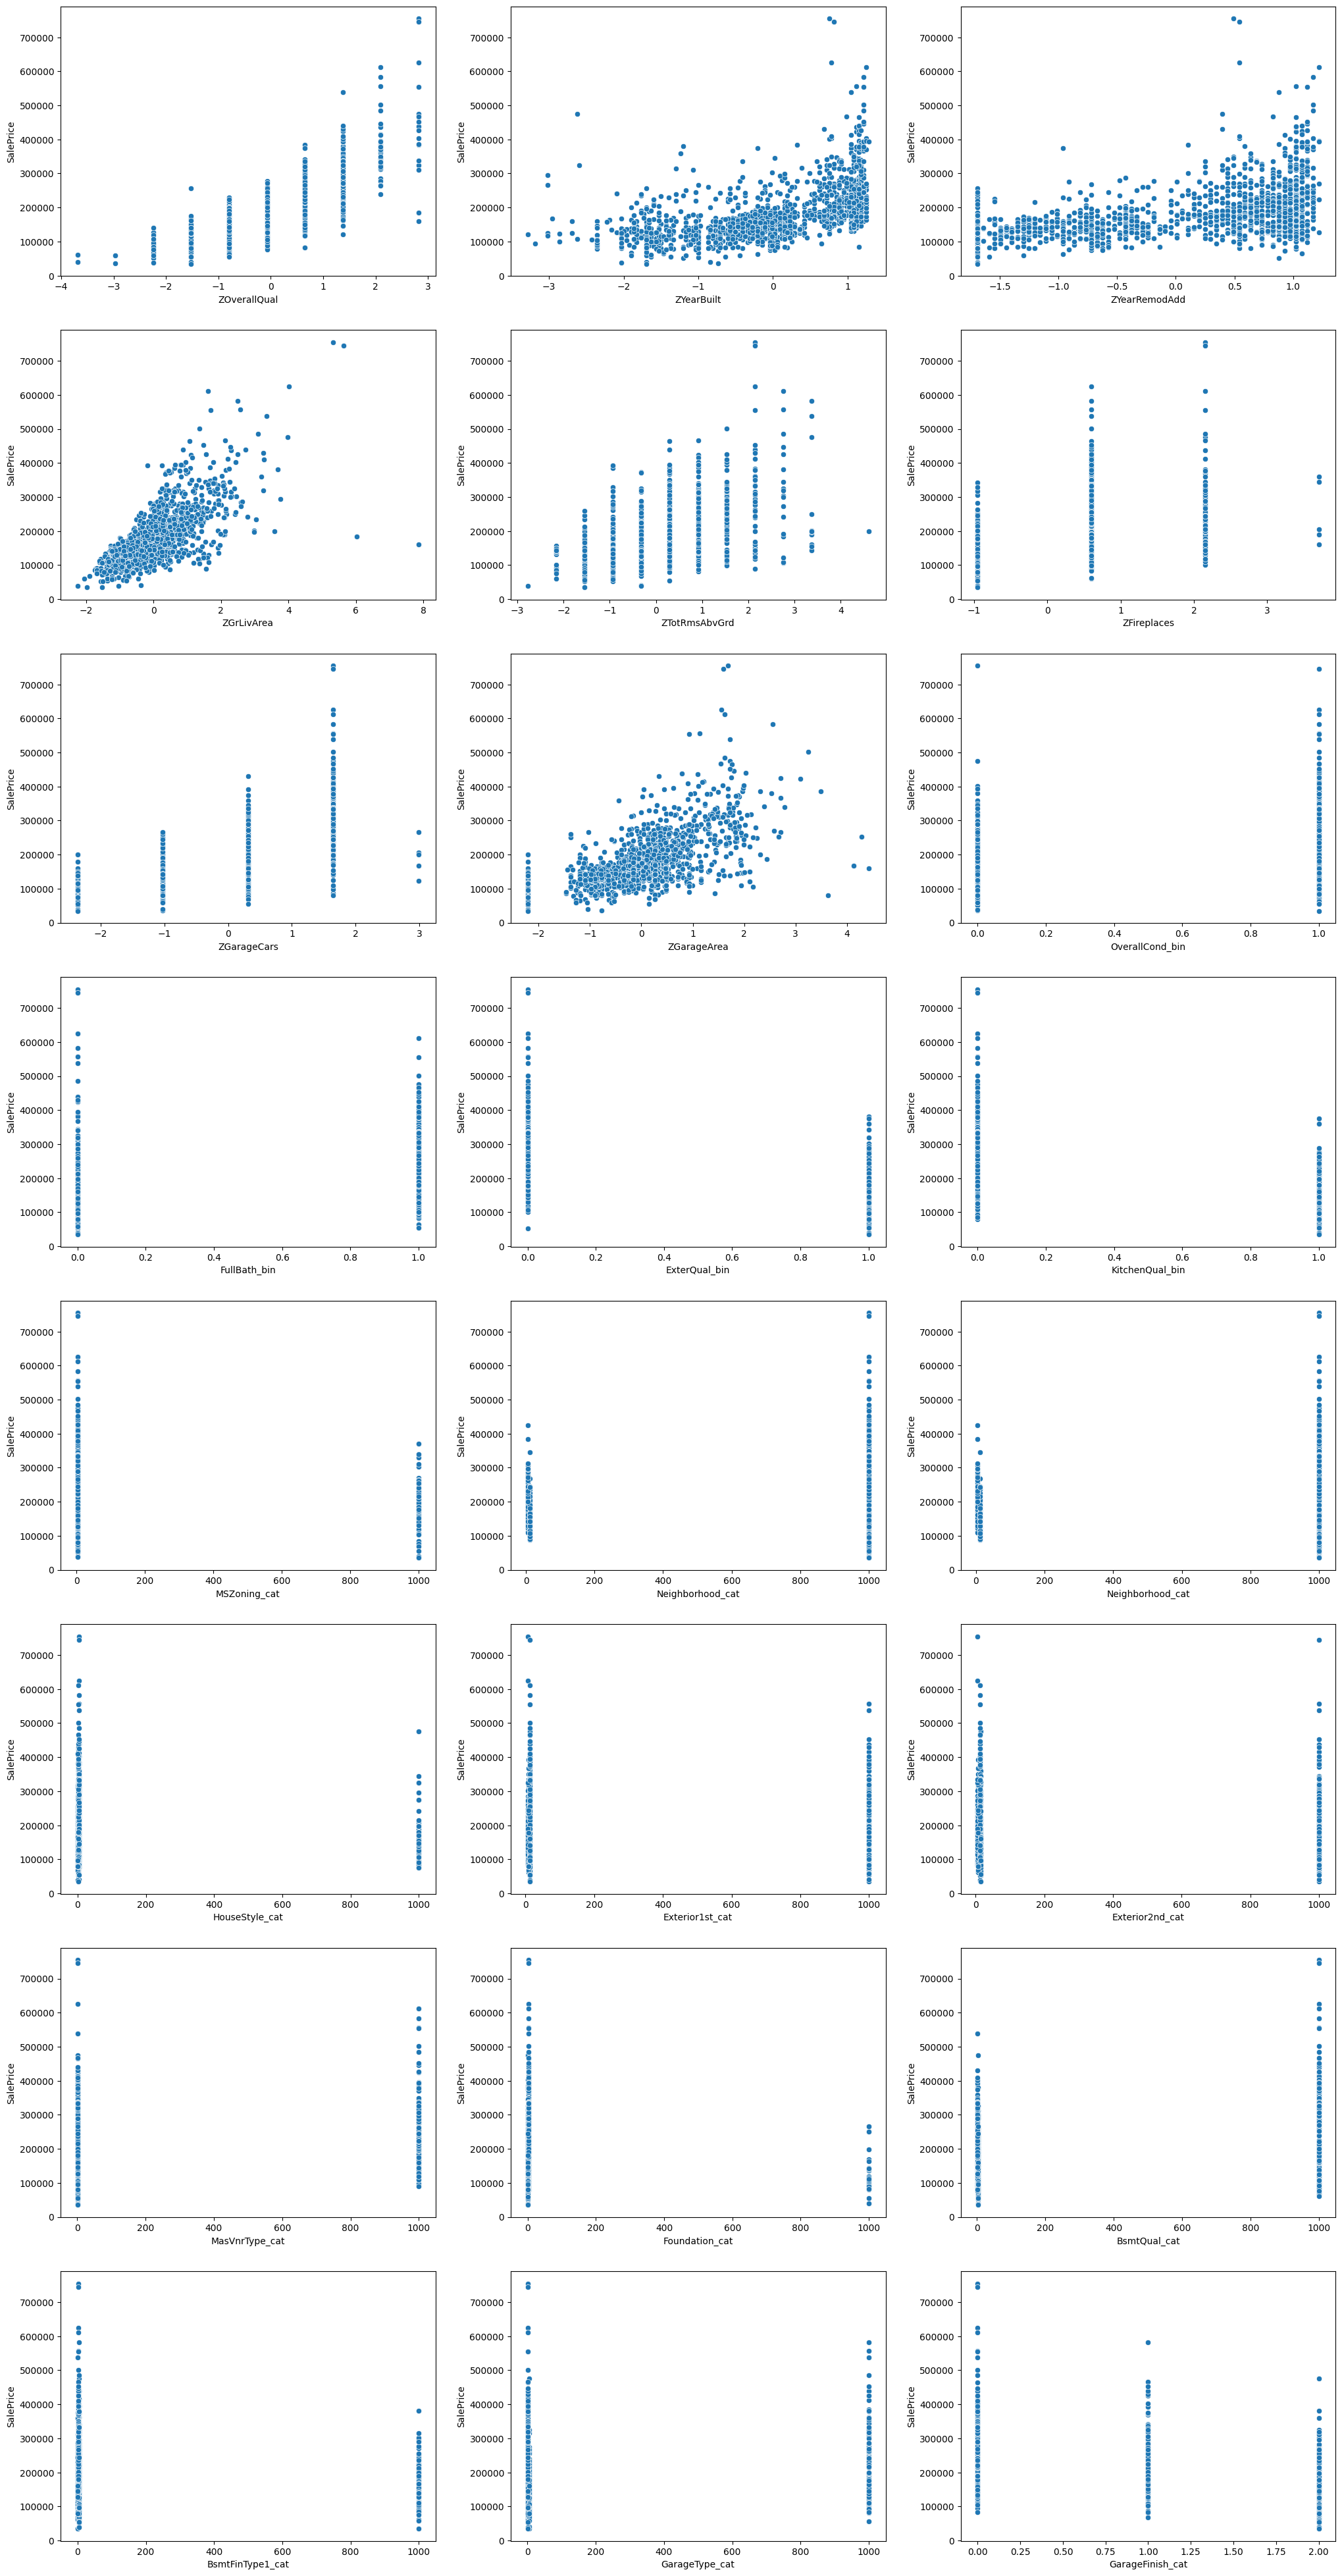

In [46]:
# Create figure object with subplots
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(25,50))

# Loop through variables selected for the model and put each subplot on a matplotlib axis object
for col, ax in zip(X.loc[:, X.columns != 'const'].columns, axes.ravel()):
#    print(col, ' ', ax)

    # Plots the pairplot
    sns.scatterplot(data=df_general_check, x=col, y='SalePrice', ax=ax)
    #sns.pairplot(df_general_check, plot_kws={"s": 50, "alpha": 0.2}, height=5, x_vars=col, y_vars='SalePrice', ax=ax)
    
plt.show()

It seems, that the assumtion is met, although some categorical variables may need further inspection.

#### Normality of the residuals

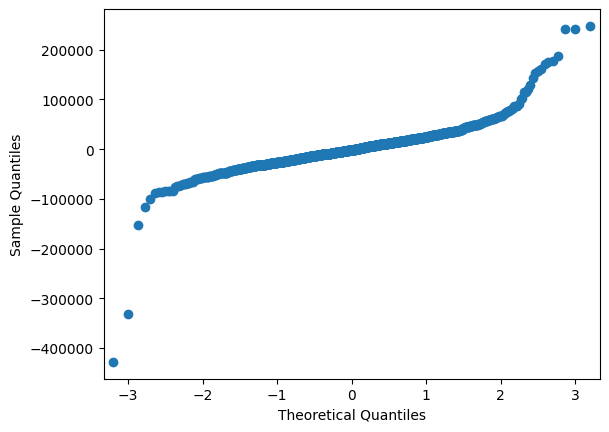

In [47]:
residuals = result.resid
sm.qqplot(residuals)
plt.show()

Here we see that despite the fact, that the overall model summary statistics suggest the normality of results, this assumption is not in fact met. Probably some relationsiphs are not linear, but rather polynomial

#### No or little Multicollinearity

In [48]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
{X.columns[i]: variance_inflation_factor(X.values, i) for i in range(1, X.shape[1])}

/usr/local/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


{'ZOverallQual': 3.317560327132964,
 'ZYearBuilt': 3.3556760609322236,
 'ZYearRemodAdd': 2.234477163268175,
 'ZGrLivArea': 4.91508130060253,
 'ZTotRmsAbvGrd': 3.485371334652329,
 'ZFireplaces': 1.4625591506698736,
 'ZGarageCars': 5.460710652408595,
 'ZGarageArea': 5.003853374314029,
 'OverallCond_bin': 1.7438665019044322,
 'FullBath_bin': 1.8669996327480245,
 'ExterQual_bin': 2.9584059204734183,
 'KitchenQual_bin': 2.5504570196610445,
 'MSZoning_cat': 1.109169886109095,
 'Neighborhood_cat': inf,
 'HouseStyle_cat': 1.0851697156923383,
 'Exterior1st_cat': 3.25929991849095,
 'Exterior2nd_cat': 3.2092180316962327,
 'MasVnrType_cat': 1.1983127155287627,
 'Foundation_cat': 1.072978530201851,
 'BsmtQual_cat': 1.2676947006039962,
 'BsmtFinType1_cat': 1.1585507232631123,
 'GarageType_cat': 1.1525957783856553,
 'GarageFinish_cat': 1.864970600298269}

As we can see there's an issue with neighberhood category as well as number of cars in garage and garage area (which is logical).

#### Homoscedascity

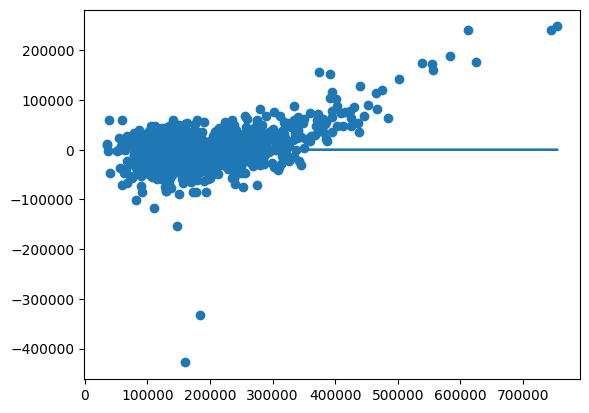

In [49]:
plt.scatter(y, residuals)
plt.plot(y, [0]*len(y))

Here we see another problem - this assumption is not met for some of the ouutliers

#### All independent variables are uncorrelated with the error term

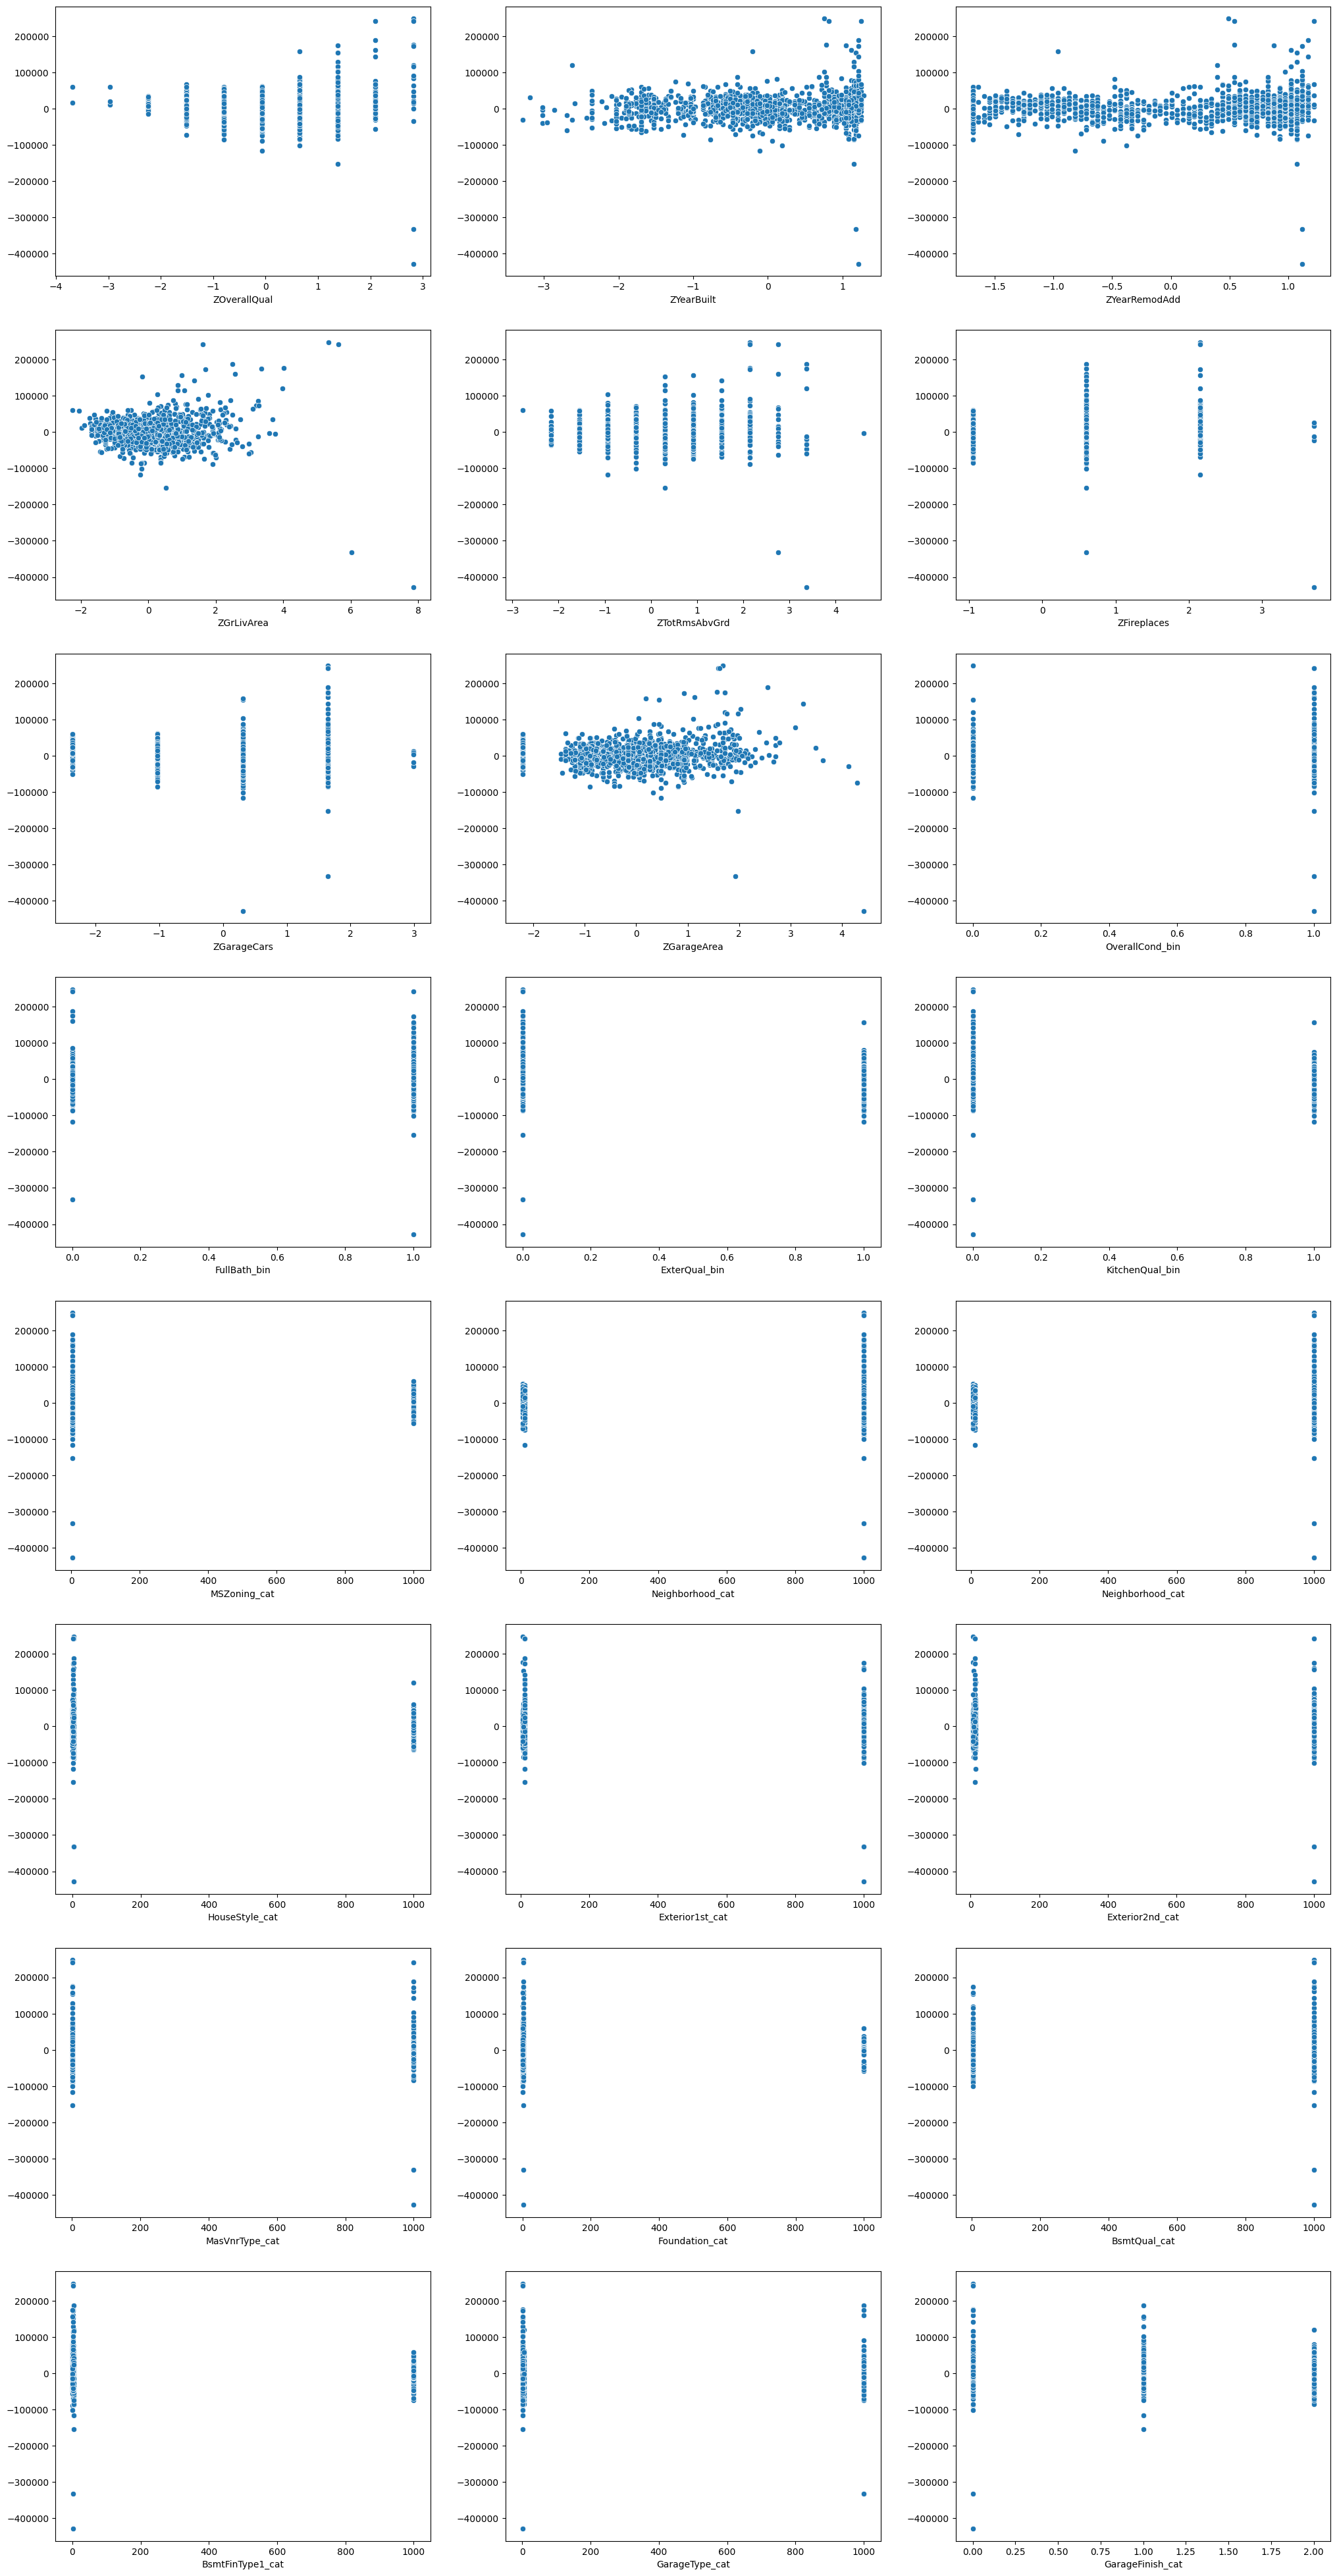

In [50]:
# Create figure object with subplots
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(25,50))

# Loop through variables selected for the model and put each subplot on a matplotlib axis object
for col, ax in zip(X.loc[:, X.columns != 'const'].columns, axes.ravel()):
#    print(col, ' ', ax)

    # Plots the pairplot
    sns.scatterplot(data=df_general_check, x=col, y=residuals, ax=ax)
    #sns.pairplot(df_general_check, plot_kws={"s": 50, "alpha": 0.2}, height=5, x_vars=col, y_vars='SalePrice', ax=ax)
    
plt.show()

Ufff... Luckily no problem found here :]

#### Observations of the error term are uncorrelated with each other

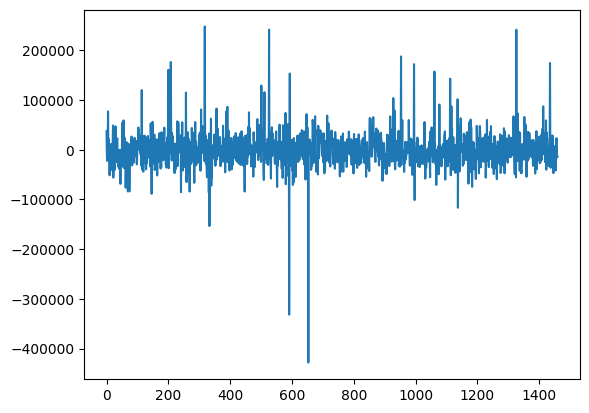

In [51]:
plt.plot(residuals.index, residuals)

It seems that this assumption is not violated

#### SUMMARY

So, to summarize our general check:
- multiple variables should have a grouping category "Other" introduced
- variables: Exterior1st_cat, Exterior2nd_cat, MSSubClass and Neighborhood_cat should be left out of the final model
- variables: one of the following: GarageArea and GarageCars should be removed
- model: maybe a weighted least squares model should be used instead of the OLS
- model: polunomial regression should be considered instead of linear one